# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!


  1. Use RAGAS to Generate Synthetic Data
  2. Load them into a LangSmith Dataset
  3. Evaluate our RAG chain against the synthetic test data
  4. Make changes to our pipeline
  5. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [4]:
!pip install -qU ragas==0.2.10

In [5]:
!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

  DEPRECATION: Building 'langdetect' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'langdetect'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [7]:
!pip install nltk

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\usvidr03\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\usvidr03\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [3]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"PSI - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [5]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - which should hopefull be familiar at this point since it's our Loan Data use-case!

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [6]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "bills/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [7]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [8]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [9]:
from ragas.testset.graph import Node, NodeType

### NOTICE: We're using a subset of the data for this example - this is to keep costs/time down.
for doc in docs[:20]:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 20, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [11]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying SummaryExtractor:   0%|          | 0/16 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node bdf01c8d-54c9-4aa8-b799-7ea310acfe14 does not have a summary. Skipping filtering.
Node 56a5396d-5714-48dd-8b88-d5faf7d9c02b does not have a summary. Skipping filtering.
Node d72e1c71-609a-4044-84f0-a8394139115b does not have a summary. Skipping filtering.
Node 7c80d053-08ed-4d99-a3f8-13a9919153ff does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/56 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 20, relationships: 136)

We can save and load our knowledge graphs as follows.

In [12]:
kg.save("bills/ai_law.json")
bills_data_kg = KnowledgeGraph.load("bills/ai_law.json")
bills_data_kg

KnowledgeGraph(nodes: 20, relationships: 136)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [13]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=bills_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [14]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

</div>


<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer :

1. SingleHopSpecificQuerySynthesizer
Enables direct, focused questions that can be answered using just one chunk of information.
Useful for testing clear and straightforward answers.

2. MultiHopAbstractQuerySynthesizer
Enables broad, general questions that require combining multiple chunks of information.
Useful for checking how well your system connects high-level ideas across documents.

3. MultiHopSpecificQuerySynthesizer
Enables detailed, multi-step questions that require reasoning across specific facts from mutliple sources.
Useful for challenging your RAG system’s ability to trace and combine specific information.
</span>


Finally, we can use our `TestSetGenerator` to generate our testset!

In [15]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What is the significance of CD0 Magazine in th...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The context references CD0 Magazine as the sou...,single_hop_specifc_query_synthesizer
1,Considering the potential rise of Artificial S...,[AI presents enormous opportunities for the Ph...,The primary concerns regarding the rise of Art...,single_hop_specifc_query_synthesizer
2,What is the AI Regulation Act?,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The Artificial Intelligence Regulation Act (AI...,single_hop_specifc_query_synthesizer
3,AI how does it help in making things better an...,"[1 \na) Promote innovation, technological adva...",The context states that AI should promote inno...,single_hop_specifc_query_synthesizer
4,What does ASI stand for in AI terminology?,[1\n2\n3\n4\n5\n6\n7\n8 \n9\n10\n11\n12\n13\n1...,Artificial Superintelligence (ASI) refers to h...,single_hop_specifc_query_synthesizer
5,How does the development and implementation of...,"[<1-hop>\n\n1 \nendorsements, voice recordings...","The recent legislative acts, including the law...",multi_hop_abstract_query_synthesizer
6,"How do legal sanctions, including fines and im...",[<1-hop>\n\n1 \nd) Take full responsibility fo...,The context indicates that AI systems responsi...,multi_hop_abstract_query_synthesizer
7,How do penalties for non-disclosure and mislab...,[<1-hop>\n\n1\n2\n3\n4\n5\n6\n7\n8 \n9\n10\n11...,Penalties for non-disclosure and mislabeling o...,multi_hop_abstract_query_synthesizer
8,how ASI maybe dangerous for future AI and how ...,[<1-hop>\n\n1\n2\n3\n4\n5\n6\n7\n8 \n9\n10\n11...,The context explains that Artificial Superinte...,multi_hop_specific_query_synthesizer
9,"How does the NAIC's jurisdiction over AI, as o...",[<1-hop>\n\n1 \nSec. 6. Jurisdiction of the NA...,The NAIC has exclusive jurisdiction over all m...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [18]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs[:20], testset_size=10)

Applying SummaryExtractor:   0%|          | 0/16 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]

Node c264110c-fb0b-476b-8082-c6fdcb2ca182 does not have a summary. Skipping filtering.
Node 0d4386a1-fd46-46dd-900a-e7631e639027 does not have a summary. Skipping filtering.
Node 165a0156-2b45-423e-b853-e7de7a51ff9e does not have a summary. Skipping filtering.
Node 7b1ca913-d610-430d-99c4-3314a832d4c2 does not have a summary. Skipping filtering.


Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/56 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [19]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What is the role of the REPBLIC OF THE PHILIPP...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,The context discusses a bill introduced by Sen...,single_hop_specifc_query_synthesizer
1,What are the concerns associated with artifici...,[AI presents enormous opportunities for the Ph...,The concerns regarding ASI include the possibi...,single_hop_specifc_query_synthesizer
2,Who is Senator PIA S. CAYETANO and what she do...,[TWENTIETH CONGRESS OF THE \nREPUBLIC OF THE P...,Senator PIA S. CAYETANO introduced the Artific...,single_hop_specifc_query_synthesizer
3,How AI should be like in the rules for Philipp...,"[1 \na) Promote innovation, technological adva...",The context states that AI should promote inno...,single_hop_specifc_query_synthesizer
4,How does the regulation of AI use by employers...,[<1-hop>\n\n1 \nd) Take full responsibility fo...,The regulation of AI use by employers involves...,multi_hop_abstract_query_synthesizer
5,How does the philippine AI law address the leg...,[<1-hop>\n\nAI presents enormous opportunities...,The philippine AI law aims to balance technolo...,multi_hop_abstract_query_synthesizer
6,How does the Philippine AI Regulation Act prom...,[<1-hop>\n\nTWENTIETH CONGRESS OF THE \nREPUBL...,The Philippine AI Regulation Act (AIRA) promot...,multi_hop_abstract_query_synthesizer
7,How does tripartite oversight help AI and sust...,[<1-hop>\n\n1 \niii) \nProof of employer engag...,Tripartite oversight involves a council with r...,multi_hop_abstract_query_synthesizer
8,how does CHED relate to AI regulation and what...,[<1-hop>\n\n1 \nSec. 6. Jurisdiction of the NA...,"CHED is listed as a member of the NAIC, which ...",multi_hop_specific_query_synthesizer
9,How do Sec. 9 and Sec. 15 of the AI Act relate...,[<1-hop>\n\n1 \nSec. 15. AI Ethics Review Boar...,Sec. 15 establishes the AI Ethics Review Board...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [20]:
from langsmith import Client

client = Client()

dataset_name = "Philippines AI Bills"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Philippines AI Bills"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [21]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [22]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [23]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [24]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [25]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Bills RAG"
)

In [26]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [27]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [28]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [29]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [30]:
rag_chain.invoke({"question" : "How much is the penalty for spreading disinformation?"})

'The penalty for using AI to create or disseminate disinformation is a fine of One Million Pesos (Php 1,000,000) to Five Million Pesos (Php 5,000,000), or imprisonment of three (3) years to ten (10) years, or both, at the discretion of the court. Additional penalties may apply if such acts are committed during election periods, public emergencies, or in violation of constitutional rights.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [31]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [32]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

empathy_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "empathy": "Is this response empathetic? Does it make the user feel like they are being heard?",
        },
        "llm" : eval_llm
    }
)

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Question #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

* Feature: The `qa_evaluator` is to check if the answer is correct (True or False) and relevant to the question and context while `labeled_helpfulness_evaluator` is best if answer is helpful to a user based on quality and utility to the user. 
* Judgement Basis: The `qa_evaluator` compares the generated answer against a grounded correct answer to asses accuracy while the `labeled_helpfulness_evaluator` compares the generated answer against a grounded truth label.
* Use Case: The `qa_evaluator` is best for extracting a specific and correct fact while the `labeled_helpfulness_evaluator` is evaluating a summarization tasks where the correct answer is subjective  and depends on the quality and utility to the user
* Analogy: The `qa_evaluator` is similar to a multiple-choice or True or False test where the answer is either right or wrong while the `labeled_helpfulness_evaluator` is similar to an essay test, where the response is graded on criteria like clarity, completeness, and overall value. 
</div>

## LangSmith Evaluation

In [33]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'back-sort-51' at:
https://smith.langchain.com/o/73c7812f-fb16-4468-bb8f-115ba901532a/datasets/358d1018-3fb1-4b19-bc11-cf0d5c0c2924/compare?selectedSessions=0b09439e-37ac-4250-a538-c13e4152346d




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,How does the DOST relate to the NAIC's jurisdi...,"Based on the context, the National AI Commissi...",None,The DOST is responsible for the composition of...,1,1,0,4.251533,57426936-f02d-453e-8680-5b6bd356a58d,e403d2a1-bb7e-4d61-be19-c952cb1ff0c1
1,how does AGI relate to AI foundation models an...,Based on the provided context:\n\nArtificial G...,None,Artificial General Intelligence (AGI) refers t...,1,1,0,10.180229,55c05a59-7c89-4aaa-b845-940ce9bfce38,7f3734ef-9174-48c6-ad7d-bc5fd536752f
2,How do Sec. 9 and Sec. 15 of the AI Act relate...,Based on the provided context:\n\n- Sec. 15 of...,None,Sec. 15 establishes the AI Ethics Review Board...,1,1,0,7.673975,adea8174-f4ee-40cb-9cf2-c0cb2b3c1156,98778cc9-9cb0-470d-ad53-f61294aefb6a
3,how does CHED relate to AI regulation and what...,I don't know.,None,"CHED is listed as a member of the NAIC, which ...",0,0,0,1.334041,03e442c3-e776-49e2-a03e-805fd06223fb,86f8b198-03a2-44f0-a2f6-9301b9513cf3
4,How does tripartite oversight help AI and sust...,I don't know.,None,Tripartite oversight involves a council with r...,0,0,0,1.367819,d983dc43-439b-445a-b60d-016867cd528f,8558babe-1fc7-42c1-9643-cabd0a7719a5
5,How does the Philippine AI Regulation Act prom...,The Philippine AI Regulation Act promotes long...,None,The Philippine AI Regulation Act (AIRA) promot...,1,0,0,2.305819,9da69a4c-88b2-4c06-aadc-d613ee6c99e9,bf0f88da-f4e0-4666-8380-deb26dd19f29
6,How does the philippine AI law address the leg...,The Philippine AI law addresses legal and regu...,None,The philippine AI law aims to balance technolo...,1,1,0,14.478915,471429b2-d52e-49d9-a465-ddee03e28dac,163c8093-b897-416d-9048-d8d7423b7377
7,How does the regulation of AI use by employers...,"Based on the provided context, the regulation ...",None,The regulation of AI use by employers involves...,1,1,0,4.033077,004001de-e144-4f68-a704-c5e34a2442eb,834160e9-7443-4810-8ef3-6679cb756a76
8,How AI should be like in the rules for Philipp...,Based on the provided context from the AI Regu...,None,The context states that AI should promote inno...,1,1,0,5.420654,81b14411-d0d1-45e4-9e03-0a34354b63d2,c17d8706-a431-4571-b59c-a8698daf872c
9,Who is Senator PIA S. CAYETANO and what she do...,"Based on the provided context, Senator Pia S. ...",None,Senator PIA S. CAYETANO introduced the Artific...,1,1,0,2.982472,9c8d9bf7-bdde-4d04-998d-6d091dd19656,d8d7eacd-1bb5-41b2-bfa8-a24d11a4950e


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [35]:
EMPATHY_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the question using empathy and kindness, and make sure the user feels heard.

Context: {context}
Question: {question}
"""

empathy_rag_prompt = ChatPromptTemplate.from_template(EMPATHY_RAG_PROMPT)

In [36]:
rag_documents = docs

In [37]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:
*Modifying the chunk_size impacts the performance of RAG applications by changing how information is retrieved and processed. The size of your chunks affects the trade-off between relevance, context, and cost.

*Small chunks are highly relevant and easier for retriever to access but may lack the full context needed for a good answer while large chunks provide more context but can be diluted with irrelevant information, hurting retrieval.

*The optimal chunk_size is finding the sweet spot/balance for your specific data and application. You want a chunk that is large enough to contain sufficient context but small enough to remain highly relevant to a specific query.

</div>

In [38]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer :
The embedding model purpose is to convert data (Image, video, text, audio) into numerical representations such as vectors. They key to its performance is how well it can capture the semantic meaning of those data.

__Semantic Similarity__: A good embedding model places the numerical representations of data close together, which is crucial for accurately matching queries to documents.

__Retrieval Accuracy__: The better the embedding model, the better the system to retrieve the correct and most relevant documents to answer a question.

__Cost and Speed__: Different embedding models offer a trade-off between speed and cost, so you need to choose one that balances performance with your budget.

</div>

In [39]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Bills RAG 2"
)

In [40]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [41]:
empathy_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | empathy_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [42]:
empathy_rag_chain.invoke({"question" : "Why is the Philippines AI Bill important?"})

"Thank you for your thoughtful question. Based on the context provided, the Philippines AI Bill is important because it aims to carefully balance encouraging technological innovation while ensuring that AI systems remain safe, ethical, transparent, and under meaningful human oversight. It recognizes that AI is still in its early stages and provides a general framework to support responsible and lawful development of AI. The bill envisions a future where AI supports Filipino ingenuity, addresses national development challenges, and protects the rights and welfare of every citizen. Importantly, it underscores the State's responsibility to prevent AI from being used to commit crimes, abuse rights, or cause harm, whether intentional or accidental, all while promoting technological progress. This thoughtful approach shows a compassionate commitment to both innovation and the well-being of the Filipino people, which is truly commendable. If you have more questions or need further clarificati

Finally, we can evaluate the new chain on the same test set!

In [43]:
evaluate(
    empathy_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        empathy_evaluator
    ],
    metadata={"revision_id": "empathy_rag_chain"},
)

View the evaluation results for experiment: 'new-mist-34' at:
https://smith.langchain.com/o/73c7812f-fb16-4468-bb8f-115ba901532a/datasets/358d1018-3fb1-4b19-bc11-cf0d5c0c2924/compare?selectedSessions=e7c73fe6-d72f-4c5f-b147-09d4c4b7576f




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.empathy,execution_time,example_id,id
0,How does the DOST relate to the NAIC's jurisdi...,Thank you for your thoughtful question. Based ...,None,The DOST is responsible for the composition of...,1,1,1,5.164965,57426936-f02d-453e-8680-5b6bd356a58d,afa0b55c-4c92-43b3-869e-6ef60e35026b
1,how does AGI relate to AI foundation models an...,Thank you for your thoughtful question. Based ...,None,Artificial General Intelligence (AGI) refers t...,1,1,1,5.511148,55c05a59-7c89-4aaa-b845-940ce9bfce38,a95283b3-472e-407e-853e-f7176600738b
2,How do Sec. 9 and Sec. 15 of the AI Act relate...,Thank you for your thoughtful question. Based ...,None,Sec. 15 establishes the AI Ethics Review Board...,1,0,1,6.806758,adea8174-f4ee-40cb-9cf2-c0cb2b3c1156,0ffbe385-449d-40c7-be21-fb866df9b773
3,how does CHED relate to AI regulation and what...,Thank you for your thoughtful question. Based ...,None,"CHED is listed as a member of the NAIC, which ...",0,0,1,6.133310,03e442c3-e776-49e2-a03e-805fd06223fb,5c3380ce-c396-4b50-9c5b-d0eaadd31b1d
4,How does tripartite oversight help AI and sust...,Thank you for your thoughtful question. Based ...,None,Tripartite oversight involves a council with r...,0,0,1,4.172752,d983dc43-439b-445a-b60d-016867cd528f,499037ca-30ff-4abc-b38a-c64cd384ad47
5,How does the Philippine AI Regulation Act prom...,Thank you for your thoughtful question. From t...,None,The Philippine AI Regulation Act (AIRA) promot...,0,0,1,4.493779,9da69a4c-88b2-4c06-aadc-d613ee6c99e9,83264ef5-f737-4fac-8998-1c3d3e885025
6,How does the philippine AI law address the leg...,Thank you for your thoughtful question. From t...,None,The philippine AI law aims to balance technolo...,1,0,1,6.140705,471429b2-d52e-49d9-a465-ddee03e28dac,e74b41a5-55fb-4dab-8988-51451e746009
7,How does the regulation of AI use by employers...,Thank you for your thoughtful question. From t...,None,The regulation of AI use by employers involves...,1,0,1,3.918963,004001de-e144-4f68-a704-c5e34a2442eb,a6ca49cf-15fd-4906-b50e-b5691e6455f6
8,How AI should be like in the rules for Philipp...,Thank you for your thoughtful question. It’s c...,None,The context states that AI should promote inno...,1,1,1,6.652674,81b14411-d0d1-45e4-9e03-0a34354b63d2,fadf843f-e2ac-458b-b8b8-7197c0301921
9,Who is Senator PIA S. CAYETANO and what she do...,Thank you for your thoughtful question. Based ...,None,Senator PIA S. CAYETANO introduced the Artific...,1,1,1,3.283365,9c8d9bf7-bdde-4d04-998d-6d091dd19656,f9a19cfa-ff02-4628-a833-34540fbbdd89


<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

#### 🏗️ Question #4:

Explain why you believe certain metrics changed in certain ways, and provide a screenshot of the difference between the two chains.

</div>

<div style="background-color: #204B8E; color: white; padding: 10px; border-radius: 5px;">

### Answer:

1. rag_chain results are direct and factual answer.
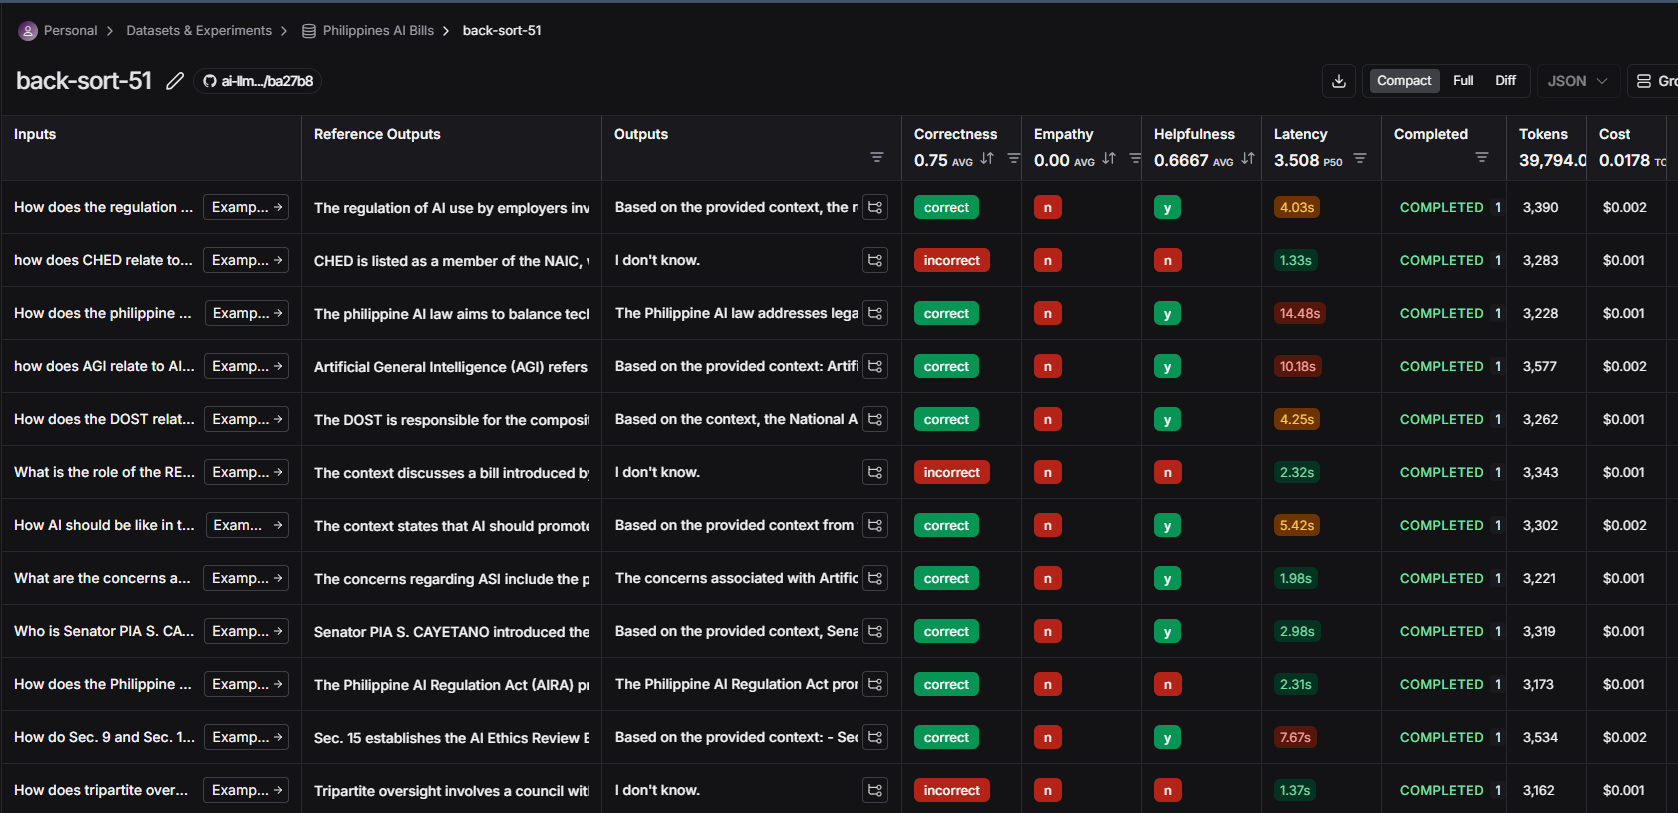


2. empathy_rag_chain results are more conversational and empathetic, which resulted in a significant shift in its performance metrics (Correctness, Emphaty and Helpfulness)
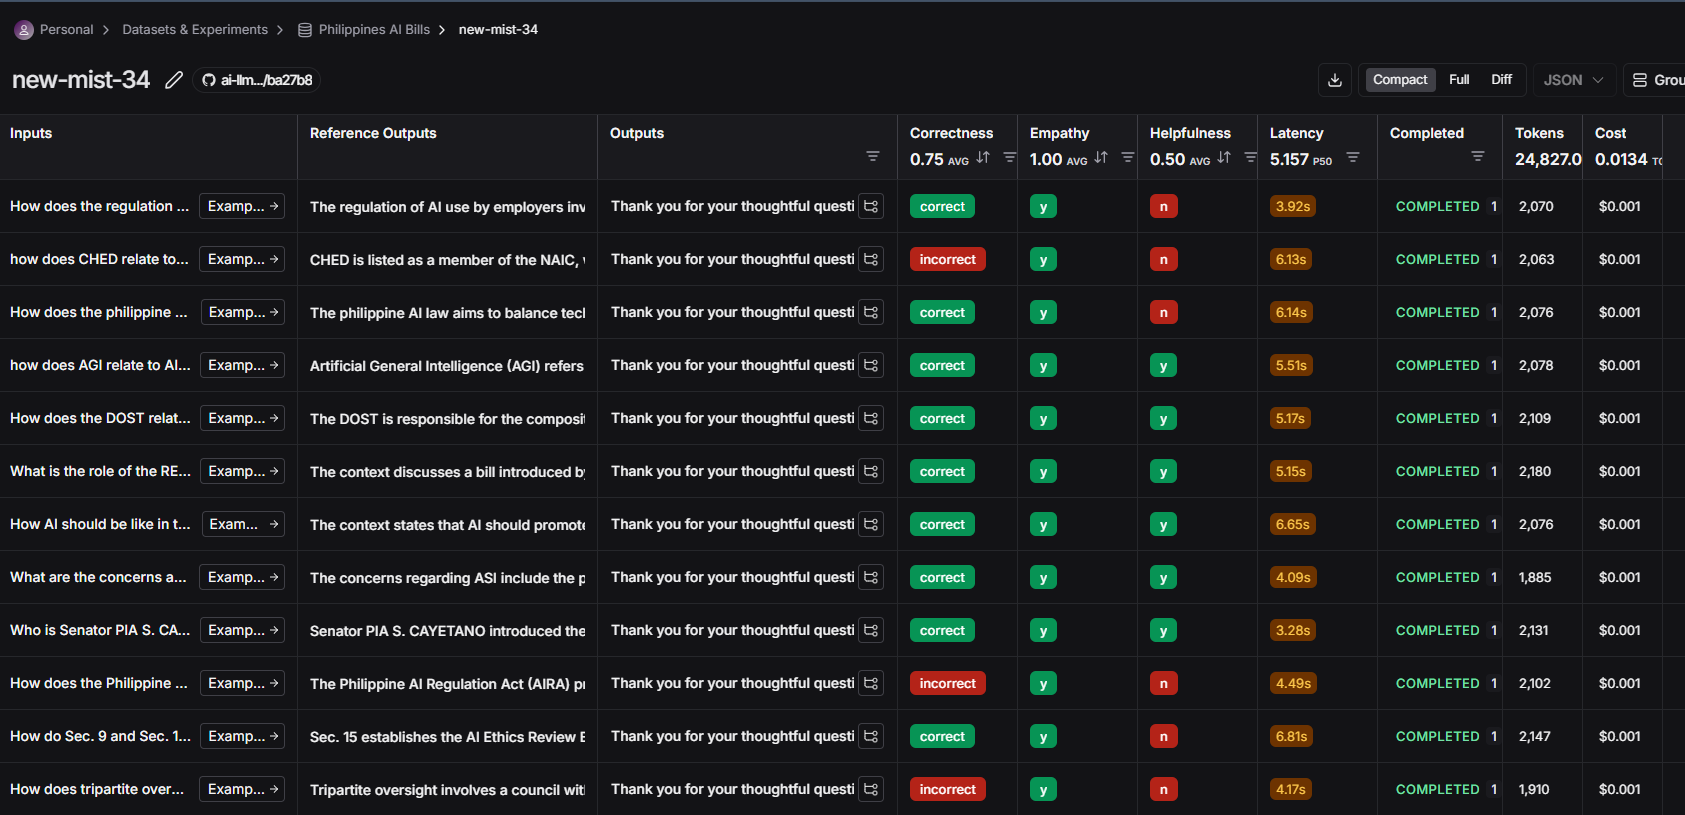
</div>

__Detailed Comparison__:

__Empathy__: This is the highlight of the 2nd version(empathy_rag_chain) as the rag_chain has an average of Empathy of 0.00 indicates direct and non-conversational response. The second run has an average Empathy of 1.00, which is a perfect score resulting from a polite phrase.

__Helpfulness__: Decreased from 0.6667 to 0.50. The empathy_rag_chain while polite, is not actually helpful in answering the user's question. The model is sacrificing factual utility for conversational tone.

__Latency__:  The average latency increased from 3.508s to 5.157s. The empathy_rag_chain is slower while the rag_chain is faster

__Cost & Tokens__: The total tokens and cost decreased significantly from 39,794 tokens ($0.0178) to 24,827 tokens ($0.0134). This is because the empathetic response ("Thank you for your thoughtful question!") is very short and consistent, using far fewer tokens than the detailed, factual answers from the first model.

__Correctness__: stayed the same because the evaluation system sometimes counted the polite, non-answers as correct. 


In [ ]:
#Assignment